## Exemplo Redes Recorrentes
### Coletando a base de dados
Bike Sharing Dataset

https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip

--2020-10-27 16:56:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K  1.03MB/s    in 0.3s    

2020-10-27 16:56:15 (1.03 MB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]



In [ ]:
!ls

Bike-Sharing-Dataset.zip  sample_data


In [ ]:
!unzip Bike-Sharing-Dataset.zip

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [ ]:
!ls

Bike-Sharing-Dataset.zip  day.csv  hour.csv  Readme.txt  sample_data


In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
data = pd.read_csv('hour.csv')

In [ ]:
data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [ ]:
data.shape

(17379, 17)

In [ ]:
data = data[['dteday','cnt']]

In [ ]:
data.dtypes

dteday    object
cnt        int64
dtype: object

In [ ]:
import matplotlib.pyplot as plt

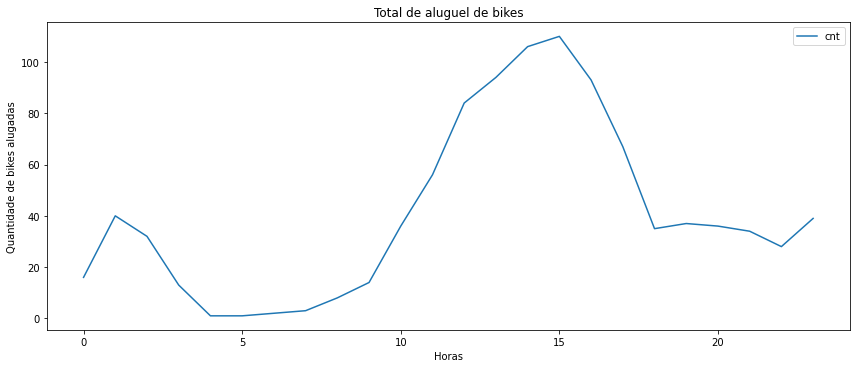

In [ ]:
data[:24].plot(figsize=(12,5))
plt.ylabel('Quantidade de bikes alugadas')
plt.xlabel('Horas')
plt.tight_layout()
plt.title('Total de aluguel de bikes')
plt.show()

### Conjuntos de treino e teste

Gerar dados para treinar o regressor da série temporal

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
ts = data['cnt'].values #numpy.ndarray
ts = np.reshape(ts, (-1, 1))

In [ ]:
ts[0]

array([16])

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
ts = scaler.fit_transform(ts)

In [ ]:
ts[:30]

array([[0.01536885],
       [0.03995902],
       [0.0317623 ],
       [0.01229508],
       [0.        ],
       [0.        ],
       [0.00102459],
       [0.00204918],
       [0.00717213],
       [0.01331967],
       [0.03586066],
       [0.05635246],
       [0.08504098],
       [0.09528689],
       [0.10758197],
       [0.11168033],
       [0.0942623 ],
       [0.06762295],
       [0.03483607],
       [0.03688525],
       [0.03586066],
       [0.03381148],
       [0.02766393],
       [0.03893443],
       [0.01639344],
       [0.01639344],
       [0.00819672],
       [0.00512295],
       [0.00204918],
       [0.00102459]])

In [ ]:
train_size = int(len(ts) * 0.80)
test_size = len(ts) - train_size
print(train_size)
print(test_size)

13903
3476


In [ ]:
train, test = ts[0:train_size,:], ts[train_size:len(ts),:]

In [ ]:
print(train.shape)
print(test.shape)

(13903, 1)
(3476, 1)


In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 24
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
print(X_train.shape)
print(X_test.shape)

(13878, 1, 24)
(3451, 1, 24)


In [ ]:
X_train[0]

array([[0.01536885, 0.03995902, 0.0317623 , 0.01229508, 0.        ,
        0.        , 0.00102459, 0.00204918, 0.00717213, 0.01331967,
        0.03586066, 0.05635246, 0.08504098, 0.09528689, 0.10758197,
        0.11168033, 0.0942623 , 0.06762295, 0.03483607, 0.03688525,
        0.03586066, 0.03381148, 0.02766393, 0.03893443]])

### Criando uma LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2], )))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               50000     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 50,101
Trainable params: 50,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='sgd')

In [ ]:
history = model.fit(X_train, Y_train, epochs=200, batch_size=30, validation_split=0.2, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0003)], verbose=1, shuffle=False)

Epoch 1/200
371/371 [==============================] - 1s 3ms/step - loss: 0.0205 - val_loss: 0.0487
Epoch 2/200
371/371 [==============================] - 1s 2ms/step - loss: 0.0182 - val_loss: 0.0425
Epoch 3/200
371/371 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0376
Epoch 4/200
371/371 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0335
Epoch 5/200
371/371 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0301
Epoch 6/200
371/371 [==============================] - 1s 2ms/step - loss: 0.0117 - val_loss: 0.0274
Epoch 7/200
371/371 [==============================] - 1s 2ms/step - loss: 0.0108 - val_loss: 0.0251
Epoch 8/200
371/371 [==============================] - 1s 3ms/step - loss: 0.0101 - val_loss: 0.0231
Epoch 9/200
371/371 [==============================] - 1s 4ms/step - loss: 0.0093 - val_loss: 0.0214
Epoch 10/200
371/371 [==============================] - 1s 4ms/step - loss: 0.0088 - val_lo

### Avaliando resultados do treino

In [ ]:
#Gerar predições
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
# inverter as predições (recuperar valor do MinMaxScaler)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Treino Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Treino Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Treino Mean Absolute Error: 50.84410041830505
Treino Root Mean Squared Error: 73.67122868447301
Test Mean Absolute Error: 67.1974137463075
Test Root Mean Squared Error: 98.37283587478407


Plot do treino

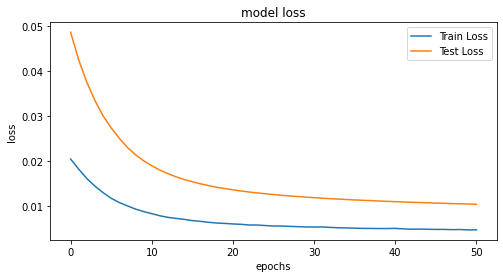

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

Comparar real e predição:

interval:  48


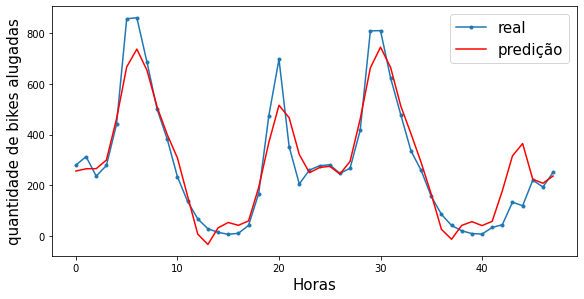

In [ ]:
interval = 48 #48 horas
print('interval: ', interval)
aa=[x for x in range(X_test[:interval].shape[0])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:X_test[:interval].shape[0]], marker='.', label="real")
plt.plot(aa, test_predict[:,0][:X_test[:interval].shape[0]], 'r', label="predição")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('quantidade de bikes alugadas', size=15)
plt.xlabel('Horas', size=15)
plt.legend(fontsize=15)
plt.show()